### Importing Packages

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist

### Configuring device to CUDA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() == True else 'cpu')
device

device(type='cuda')

### Setting up dataloaders

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.utils.data import DataLoader

# Resizing and tensorizing images for training purposes
xray_data = dataset.ImageFolder(root = 'chest_xray/chest_xray', 
                                     transform = transforms.Compose([
                                         transforms.Resize(28),
                                         transforms.CenterCrop(28),
                                         transforms.ToTensor(),
                                     ]))

# train-test split
train_size = int(.7 * len(xray_data))
test_size = len(xray_data) - train_size

train_set, test_set = torch.utils.data.random_split(xray_data, [train_size, test_size])
train_loader = idist.auto_dataloader(train_set, batch_size = 128, shuffle = True, drop_last = True)
test_loader = idist.auto_dataloader(test_set, batch_size = 128, shuffle = True, drop_last = True)

2024-06-02 00:03:41,264 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'shuffle': True, 'drop_last': True, 'pin_memory': True}
2024-06-02 00:03:41,264 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'shuffle': True, 'drop_last': True, 'pin_memory': True}


### Visualzing Training Images

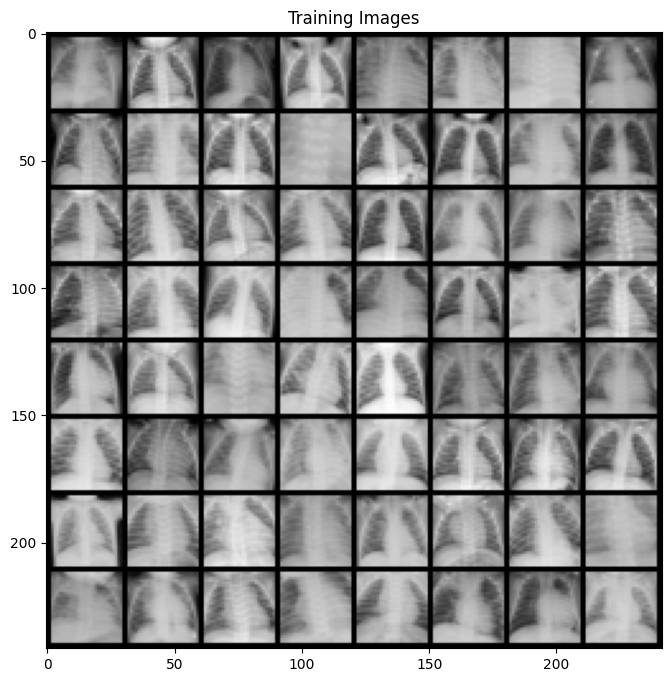

In [4]:
plt.figure(figsize = (8, 8))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(train_loader))[0][:64], padding = 2, normalize = True).cpu(), (1, 2, 0)))

### Defining the VAE model

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3a = nn.Linear(hidden_dim, latent_dim)
        self.fc3b = nn.Linear(hidden_dim, latent_dim)

        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc2(self.fc1(x)))
        mu, sigma = self.fc3a(h), self.fc3b(h)
        return mu, sigma

    def decode(self, x):
        h = self.relu(self.fc5(self.fc4(x)))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma * epsilon
        x_hat = self.decode(z_new)
        return x_hat, mu, sigma
    

### Initializing models

In [5]:
model = idist.auto_model(VAE(3 * (28 ** 2), 200, 20),  device = idist.device())

### Initializing hyperparameters

In [6]:
from torch.optim import Adam
BCE_loss = nn.BCELoss()
def loss_fcn(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction = 'sum') # conditional probability term in loss function
    KLD = 0.5 * torch.sum(mean.pow(2) + log_var.exp() - (log_var + 1)) # KL divergence term in loss function

    return reproduction_loss + KLD

optimizer = idist.auto_optim(Adam(model.parameters(), lr = .001))

### Training VAE 

In [7]:
def train(engine, data):
        model.train()
        x = data[0].view(128, 3 * (28 ** 2))
        x = x.to(idist.device())

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_fcn(x, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()

        return {
                "Loss" : loss / 128
        }

trainer = Engine(train)

In [8]:
loss_epochs = []
@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    loss_epochs.append(o["Loss"])

### Calculating FID and Inception Score

Note: All code for computing the metrics involving the functions were taken from https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

In [9]:
from ignite.metrics import FID, InceptionScore

In [10]:
fid_metric = FID(device = idist.device())
is_metric = InceptionScore(device = idist.device(), output_transform = lambda x: x[0])

In [11]:
import PIL.Image as Image


def interpolate(batch):
    # this function reshapes the images for the metric calculations
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    # this function returns the real and reconstructed batch of images
    with torch.no_grad():
        model.eval()
        batch = batch[0].to(device)
        batch = batch.view(128, 3 * (28 ** 2))
        fake = model(batch)[0]
        fake = fake.view(128, 3, 28, 28)
        batch = batch.view(128, 3, 28, 28)
        fake = interpolate(fake)
        real = interpolate(batch)
        return fake, real


In [12]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [13]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    # this function prints the metrics after every epoch is completed
    evaluator.run(test_loader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")


In [14]:
def training(*args):
    trainer.run(train_loader, max_epochs=20)

In [15]:
with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

2024-06-02 00:03:43,521 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'gloo'
2024-06-02 00:03:43,522 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x000001D12CFB3E20>' in 1 processes
c:\Users\alihu\Documents\UCSD_COURSES\ECE175B\myenv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/5] Metric Scores
*   FID : 0.107886
*    IS : 1.019100
Epoch [2/5] Metric Scores
*   FID : 0.095667
*    IS : 1.052309
Epoch [3/5] Metric Scores
*   FID : 0.094472
*    IS : 1.105287
Epoch [4/5] Metric Scores
*   FID : 0.083025
*    IS : 1.180783
Epoch [5/5] Metric Scores
*   FID : 0.079495
*    IS : 1.169156
Epoch [6/5] Metric Scores
*   FID : 0.074360
*    IS : 1.182683
Epoch [7/5] Metric Scores
*   FID : 0.079980
*    IS : 1.180340
Epoch [8/5] Metric Scores
*   FID : 0.068882
*    IS : 1.210623
Epoch [9/5] Metric Scores
*   FID : 0.070640
*    IS : 1.209428
Epoch [10/5] Metric Scores
*   FID : 0.069565
*    IS : 1.202105
Epoch [11/5] Metric Scores
*   FID : 0.067536
*    IS : 1.193972
Epoch [12/5] Metric Scores
*   FID : 0.062245
*    IS : 1.214518
Epoch [13/5] Metric Scores
*   FID : 0.064866
*    IS : 1.205601
Epoch [14/5] Metric Scores
*   FID : 0.068644
*    IS : 1.194854
Epoch [15/5] Metric Scores
*   FID : 0.070494
*    IS : 1.197208
Epoch [16/5] Metric Scores
*   FID

2024-06-02 00:23:33,542 ignite.distributed.launcher.Parallel INFO: End of run
2024-06-02 00:23:33,543 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'gloo'


Epoch [20/5] Metric Scores
*   FID : 0.058527
*    IS : 1.232364


### Loss/Metric Curves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


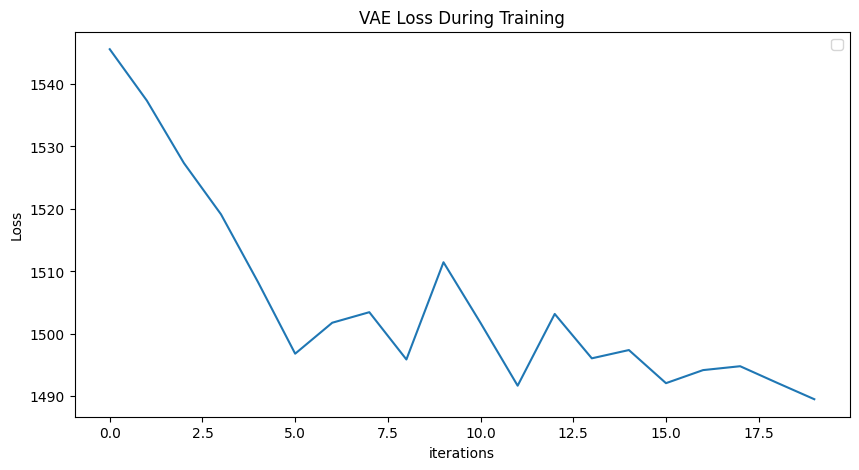

In [23]:
plt.figure(figsize=(10,5))
plt.title("VAE Loss During Training")
plt.plot(loss_epochs)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

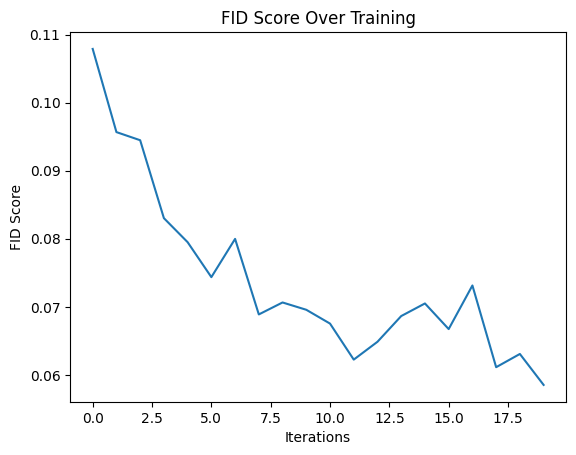

In [28]:
plt.title("FID Score Over Training")
plt.xlabel("Iterations")
plt.ylabel("FID Score")
plt.plot(fid_values, label = 'FID')

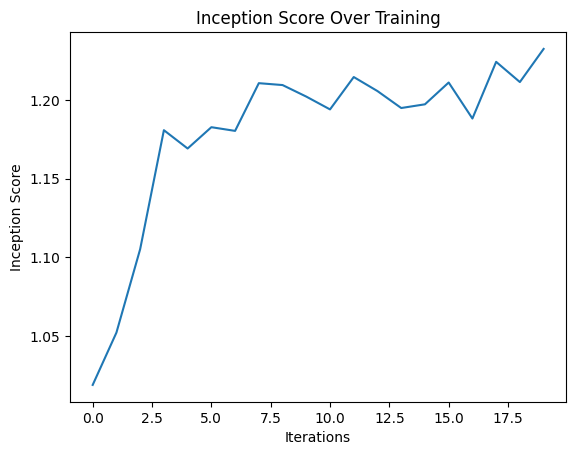

In [29]:
plt.title("Inception Score Over Training")
plt.xlabel("Iterations")
plt.ylabel("Inception Score")
plt.plot(is_values)

### Examples of Generated Images

In [31]:
model.eval()
for images, _ in test_loader:
    with torch.no_grad():
        images = images.view(128, 3 * (28 ** 2))
        images = images.to(device)
        fake_images= model(images)[0]
    break

fake_images = fake_images.view(-1, 3, 28, 28)
fake_images[:64, :, :, :].shape

torch.Size([64, 3, 28, 28])

In [32]:
train_loader

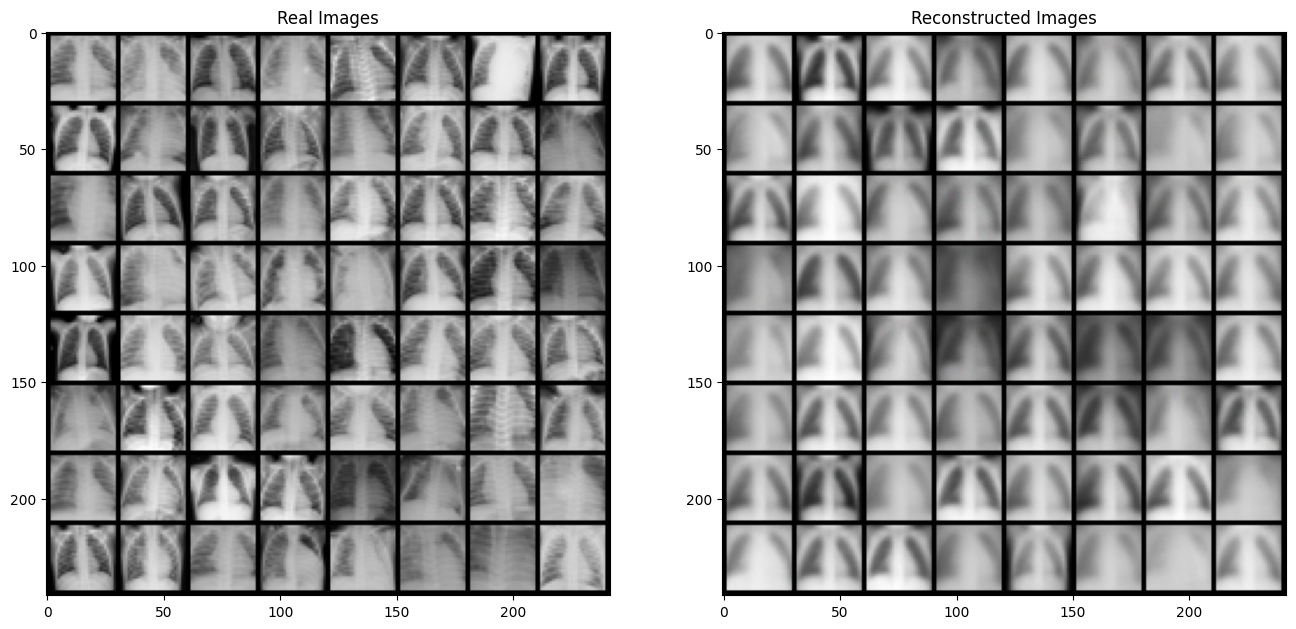

In [34]:
model.to(device = idist.device())
model.eval()
fig, axes = plt.subplots(1, 2, figsize = (16, 16))
axes[0].set_title("Real Images")
axes[0].imshow(np.transpose(vutils.make_grid(next(iter(test_loader))[0][:64], padding = 2, normalize = True).cpu(), (1, 2, 0)))
axes[1].set_title("Reconstructed Images")
axes[1].imshow(np.transpose(vutils.make_grid(fake_images[:64, :, :, :].cpu(), padding = 2, normalize = True), (1, 2, 0)))